In [1]:
a = 10

def add_1():
    return 1 + a

In [2]:
add_1()

11

In [3]:
a = 11
add_1()

12

In [13]:
a = 1
for i in range(10):
    print(i, a, a*i, a + a*i, add_1())
    a = a + a*i
    

0 1 0 1 2
1 1 1 2 2
2 2 4 6 3
3 6 18 24 7
4 24 96 120 25
5 120 600 720 121
6 720 4320 5040 721
7 5040 35280 40320 5041
8 40320 322560 362880 40321
9 362880 3265920 3628800 362881


Pre-wire ADN to RSC-HD

In [ ]:
import numpy as np

N_adn = 180
N_hd = 180

x_adn = np.linspace(0, 360, N_adn, endpoint=False)
x_hd = np.linspace(0, 360, N_hd, endpoint=False)

sigma = 10 

# circular distance matrix
delta = np.abs(x_hd[:, None] - x_adn[None, :])
delta = np.minimum(delta, 360 - delta)

W4 = np.exp(-0.5 * (delta / sigma)**2)

Text(0, 0.5, 'RSC HD cells (postsynaptic)')

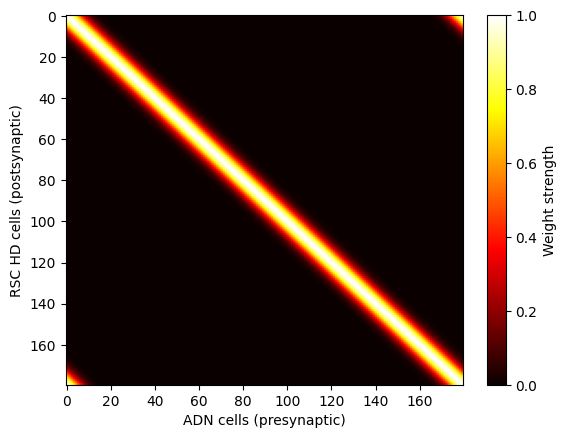

In [15]:
import matplotlib.pyplot as plt

plt.imshow(W4, aspect='auto', cmap='hot')
plt.colorbar(label='Weight strength')
plt.xlabel('ADN cells (presynaptic)')
plt.ylabel('RSC HD cells (postsynaptic)')

Pre-wire RSC-HD to ADN

In [16]:
x_hd = np.linspace(0, 360, N_hd, endpoint=False)
x_adn = np.linspace(0, 360, N_adn, endpoint=False)
sigma = 10  

# circular distances
delta = np.abs(x_adn[:, None] - x_hd[None, :])
delta = np.minimum(delta, 360 - delta)

W5 = np.exp(-0.5 * (delta / sigma)**2)

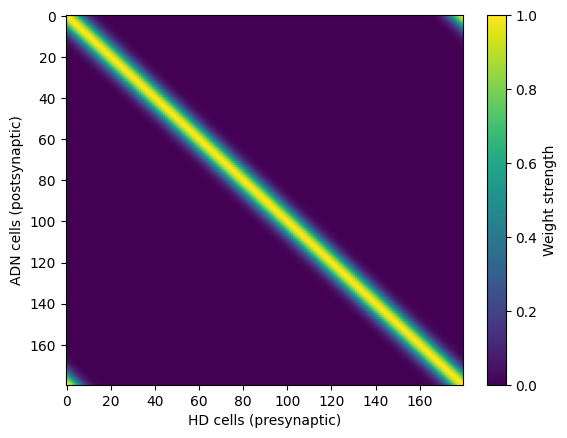

In [17]:
plt.imshow(W5, aspect='auto', cmap='viridis')
plt.xlabel('HD cells (presynaptic)')
plt.ylabel('ADN cells (postsynaptic)')
plt.colorbar(label='Weight strength')

### ADN Firing Rate

Text(0.5, 1.0, 'ADN Firing Rate Activity Over Time')

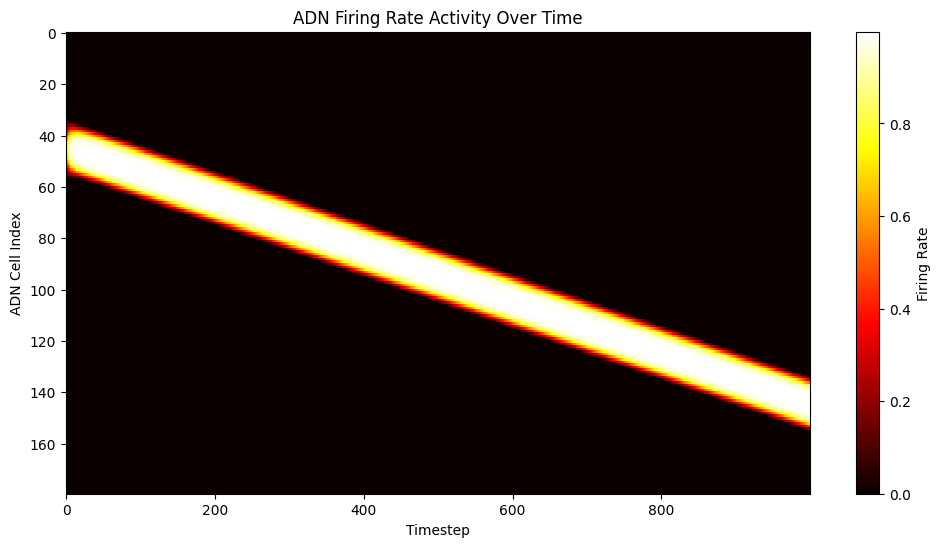

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ======================
# Simulation Parameters
# ======================
N_adn = 180             # Number of ADN cells
timesteps = 1000        # Number of simulation steps
tau = 0.001             # Time constant
delta_t = 0.0001        # Timestep size
g_inhib = 5             # Global inhibition
A_PI = 4                # Path integration input strength
sigma_PI = 10           # Width of PI Gaussian
sigma_adn = 10          # Width of ADN-ADN recurrent weights
delta_theta = 0.2       # Head movement per timestep (degrees)

# ============================
# Preferred Firing Directions
# ============================
x_adn = np.linspace(0, 360, N_adn, endpoint=False)

# ==================================
# Pre-wire Recurrent Weights (W6)
# ==================================
delta = np.abs(x_adn[:, None] - x_adn[None, :])
delta = np.minimum(delta, 360 - delta)  # wraparound circular distance
W6 = np.exp(-0.5 * (delta / sigma_adn) ** 2)

# ==========================
# State Initialization
# ==========================
a_adn = np.zeros(N_adn)   # activation levels
r_adn = np.zeros(N_adn)   # firing rates
x_est = 90                # Initial estimated direction

# Store ADN activity over time
adn_activity = np.zeros((timesteps, N_adn))

# ==========================
# Simulation Loop
# ==========================
for t in range(timesteps):
    # Add noisy drift to PI estimate
    noise = np.random.normal(loc=0.005 * delta_theta, scale=0.005 * delta_theta)
    x_est = (x_est + delta_theta + noise) % 360

    # Path integration input
    delta_PI = np.abs(x_adn - x_est)
    delta_PI = np.minimum(delta_PI, 360 - delta_PI)
    PI_input = A_PI * np.exp(-0.5 * (delta_PI / sigma_PI)**2)

    # Compute recurrent input and inhibition
    recurrent_input = (1 / N_adn) * W6 @ r_adn
    inhibition = (g_inhib / N_adn) * np.sum(r_adn)

    # Forward Euler update
    da_dt = (-a_adn - inhibition + recurrent_input + PI_input) / tau
    a_adn += da_dt * delta_t

    # Firing rate via rectified tanh
    r_adn = np.maximum(0, np.tanh(a_adn))

    # Record activity
    adn_activity[t] = r_adn

# ==========================
# Visualization
# ==========================
plt.figure(figsize=(12, 6))
plt.imshow(adn_activity.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Firing Rate')
plt.xlabel('Timestep')
plt.ylabel('ADN Cell Index')
plt.title('ADN Firing Rate Activity Over Time')


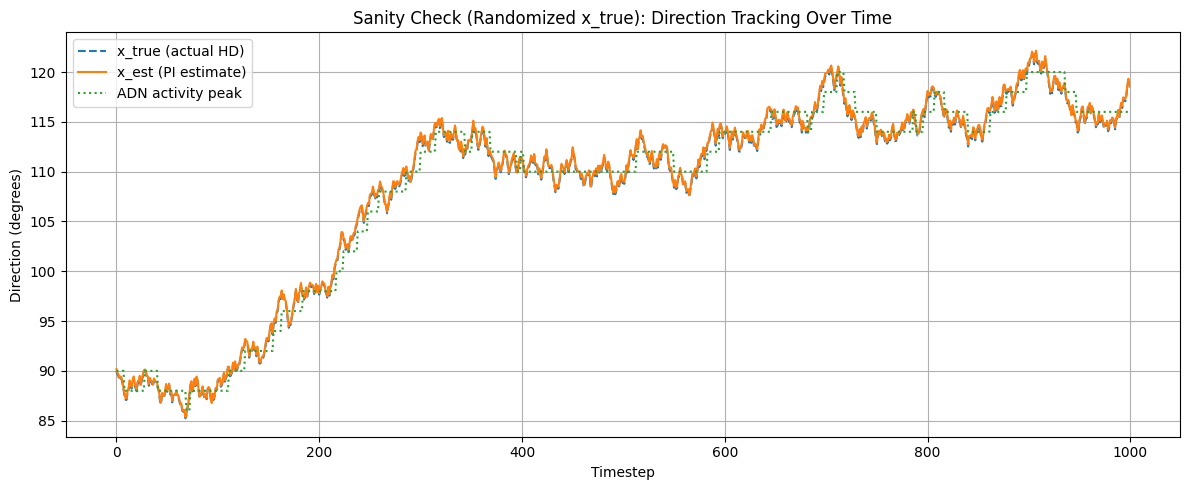

(np.float64(1.0109398758428607), np.float64(3.9375561213892354))

In [20]:
# Reset state variables for randomized x_true simulation
a_adn = np.zeros(N_adn)
r_adn = np.zeros(N_adn)
x_est = 90

# Reinitialize tracking lists
x_true_history = []
x_est_history = []
peak_adn_indices = []

# Simulation loop with random x_true changes
for t in range(timesteps):
    # Random walk for x_true: sample small random change
    delta_theta_random = np.random.uniform(-1.0, 1.0)  # degrees per step
    x_true = (x_true_history[-1] + delta_theta_random) % 360 if x_true_history else 90

    noise = np.random.normal(loc=0.005 * delta_theta_random, scale=0.005 * abs(delta_theta_random))
    x_est = (x_est + delta_theta_random + noise) % 360

    x_true_history.append(x_true)
    x_est_history.append(x_est)

    delta_PI = np.abs(x_adn - x_est)
    delta_PI = np.minimum(delta_PI, 360 - delta_PI)
    PI_input = A_PI * np.exp(-0.5 * (delta_PI / sigma_PI)**2)

    recurrent_input = (1 / N_adn) * W6 @ r_adn
    inhibition = (g_inhib / N_adn) * np.sum(r_adn)

    da_dt = (-a_adn - inhibition + recurrent_input + PI_input) / tau
    a_adn += da_dt * delta_t
    r_adn = np.maximum(0, np.tanh(a_adn))
    adn_activity[t] = r_adn

    peak_adn_indices.append(np.argmax(r_adn))

# Convert peak indices to directions
peak_pfds = x_adn[peak_adn_indices]

# Plot tracking over time
plt.figure(figsize=(12, 5))
plt.plot(x_true_history, label='x_true (actual HD)', linestyle='--')
plt.plot(x_est_history, label='x_est (PI estimate)', linestyle='-')
plt.plot(peak_pfds, label='ADN activity peak', linestyle=':')
plt.ylabel('Direction (degrees)')
plt.xlabel('Timestep')
plt.title('Sanity Check (Randomized x_true): Direction Tracking Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Alignment error analysis
errors = np.abs(peak_pfds - np.array(x_est_history))
errors = np.minimum(errors, 360 - errors)
mean_error = np.mean(errors)
max_error = np.max(errors)

mean_error, max_error

ADN-RSC interaction Simulation Code

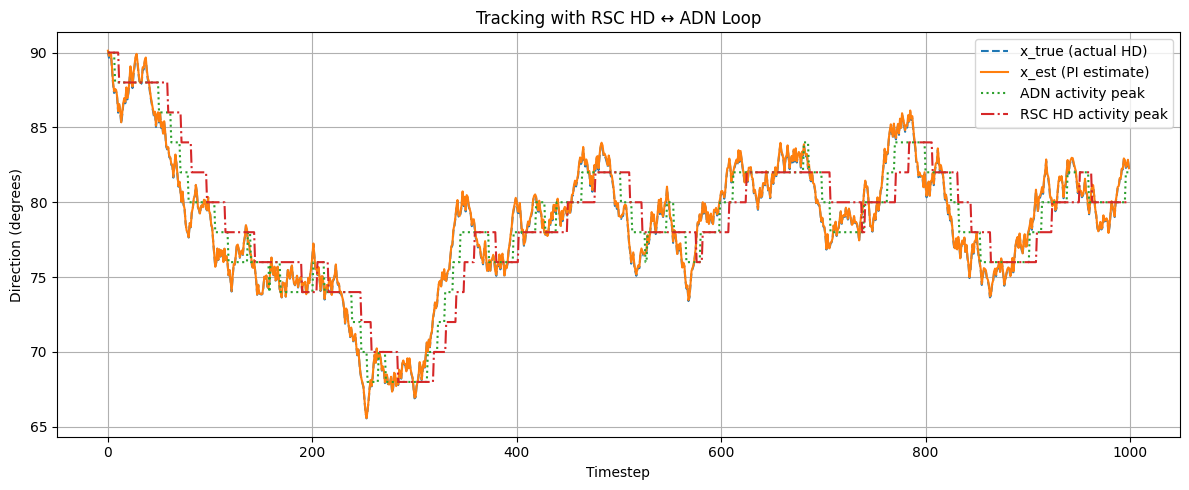

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ========== Parameters ==========
N_adn = 180
N_hd = 180
timesteps = 1000
delta_t = 0.0001
tau = 0.001
tau_hd = 0.001

g_inhib = 5     # ADN inhibition
g_hd = 20       # HD inhibition

# Path Integration input
A_PI = 4
sigma_PI = 10

# Pre-wiring widths
sigma_adn = 10
sigma_w4 = 10
sigma_w5 = 10

# Strengths
w4_strength = 120
w5_strength = 10

# Preferred directions
x_adn = np.linspace(0, 360, N_adn, endpoint=False)
x_hd = np.linspace(0, 360, N_hd, endpoint=False)

# ========== Prewire Weights ==========
# ADN <-> ADN (W6)
delta = np.abs(x_adn[:, None] - x_adn[None, :])
delta = np.minimum(delta, 360 - delta)
W6 = np.exp(-0.5 * (delta / sigma_adn)**2)

# ADN -> RSC HD (W4)
delta_w4 = np.abs(x_hd[:, None] - x_adn[None, :])
delta_w4 = np.minimum(delta_w4, 360 - delta_w4)
W4 = np.exp(-0.5 * (delta_w4 / sigma_w4)**2) * w4_strength

# RSC HD -> ADN (W5)
delta_w5 = np.abs(x_adn[:, None] - x_hd[None, :])
delta_w5 = np.minimum(delta_w5, 360 - delta_w5)
W5 = np.exp(-0.5 * (delta_w5 / sigma_w5)**2) * w5_strength

# ========== State Initialization ==========
a_adn = np.zeros(N_adn)
r_adn = np.zeros(N_adn)

a_hd = np.zeros(N_hd)
r_hd = np.zeros(N_hd)

x_est = 90  # Initial PI estimate

# ========== Tracking ==========
x_true_history = []
x_est_history = []
peak_adn_indices = []
peak_hd_indices = []

adn_activity = np.zeros((timesteps, N_adn))
hd_activity = np.zeros((timesteps, N_hd))

# ========== Simulation Loop ==========
for t in range(timesteps):
    # --- Head Direction Update ---
    delta_theta_random = np.random.uniform(-1.0, 1.0)
    x_true = (x_true_history[-1] + delta_theta_random) % 360 if x_true_history else 90
    noise = np.random.normal(loc=0.005 * delta_theta_random, scale=0.005 * abs(delta_theta_random))
    x_est = (x_est + delta_theta_random + noise) % 360

    x_true_history.append(x_true)
    x_est_history.append(x_est)

    # --- ADN Layer ---
    delta_PI = np.abs(x_adn - x_est)
    delta_PI = np.minimum(delta_PI, 360 - delta_PI)
    PI_input = A_PI * np.exp(-0.5 * (delta_PI / sigma_PI)**2)

    recurrent_adn = (1 / N_adn) * W6 @ r_adn
    inhibition_adn = (g_inhib / N_adn) * np.sum(r_adn)
    feedback_hd_to_adn = (1 / N_hd) * W5 @ r_hd

    da_dt = (-a_adn - inhibition_adn + recurrent_adn + feedback_hd_to_adn + PI_input) / tau
    a_adn += da_dt * delta_t
    r_adn = np.maximum(0, np.tanh(a_adn))
    adn_activity[t] = r_adn

    # --- RSC HD Layer ---
    inhibition_hd = (g_hd / N_hd) * np.sum(r_hd)
    input_adn_to_hd = (1 / N_adn) * W4 @ r_adn

    da_hd_dt = (-a_hd - inhibition_hd + input_adn_to_hd) / tau_hd
    a_hd += da_hd_dt * delta_t
    r_hd = np.maximum(0, np.tanh(a_hd))
    hd_activity[t] = r_hd

    # Track peaks
    peak_adn_indices.append(np.argmax(r_adn))
    peak_hd_indices.append(np.argmax(r_hd))

# ========== Plot Tracking ==========
peak_adn_pfds = x_adn[peak_adn_indices]
peak_hd_pfds = x_hd[peak_hd_indices]

plt.figure(figsize=(12, 5))
plt.plot(x_true_history, '--', label='x_true (actual HD)')
plt.plot(x_est_history, '-', label='x_est (PI estimate)')
plt.plot(peak_adn_pfds, ':', label='ADN activity peak')
plt.plot(peak_hd_pfds, '-.', label='RSC HD activity peak')
plt.xlabel('Timestep')
plt.ylabel('Direction (degrees)')
plt.title('Tracking with RSC HD ↔ ADN Loop')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mimic ADN Input

HD to CONJ

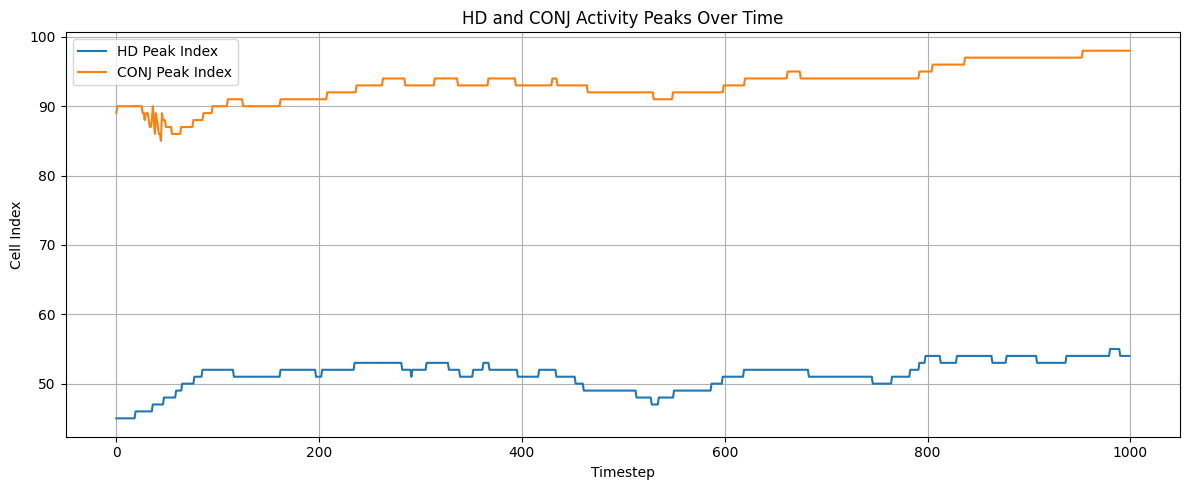

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N_hd = 180
N_conj = 360
timesteps = 1000
delta_t = 0.0001
tau = 0.001

# Inhibition parameters
g_hd = 20
g_conj = 7

# Strengths & widths for weights
w1_strength = 160  # HD → CONJ
w2_strength = 45   # CONJ → HD
sigma_w1 = 20
sigma_w2 = 20

# PFDs
x_hd = np.linspace(0, 360, N_hd, endpoint=False)
x_conj = np.linspace(0, 360, N_conj, endpoint=False)

# Prewire W1 (HD → CONJ)
delta_w1 = np.abs(x_conj[:, None] - x_hd[None, :])
delta_w1 = np.minimum(delta_w1, 360 - delta_w1)
W1 = np.exp(-0.5 * (delta_w1 / sigma_w1)**2) * w1_strength

# Prewire W2 (CONJ → HD)
delta_w2 = np.abs(x_hd[:, None] - x_conj[None, :])
delta_w2 = np.minimum(delta_w2, 360 - delta_w2)
W2 = np.exp(-0.5 * (delta_w2 / sigma_w2)**2) * w2_strength

# State variables
a_hd = np.zeros(N_hd)
r_hd = np.zeros(N_hd)

a_conj = np.zeros(N_conj)
r_conj = np.zeros(N_conj)

# Tracking
hd_activity = np.zeros((timesteps, N_hd))
conj_activity = np.zeros((timesteps, N_conj))
x_true = 90

for t in range(timesteps):
    # Simulate rotating head direction
    delta_theta = np.random.uniform(-1.0, 1.0)
    x_true = (x_true + delta_theta) % 360

    # Activate HD layer directly from x_true (for testing)
    delta_hd = np.abs(x_hd - x_true)
    delta_hd = np.minimum(delta_hd, 360 - delta_hd)
    hd_input = np.exp(-0.5 * (delta_hd / 10)**2) * 4  # mimic input like ADN

    # HD dynamics with input from CONJ
    conj_to_hd = (1 / N_conj) * W2 @ r_conj
    inhibition_hd = (g_hd / N_hd) * np.sum(r_hd)
    da_hd_dt = (-a_hd - inhibition_hd + conj_to_hd + hd_input) / tau
    a_hd += da_hd_dt * delta_t
    r_hd = np.maximum(0, np.tanh(a_hd))
    hd_activity[t] = r_hd

    # CONJ dynamics with input from HD
    hd_to_conj = (1 / N_hd) * W1 @ r_hd
    inhibition_conj = (g_conj / N_conj) * np.sum(r_conj)
    da_conj_dt = (-a_conj - inhibition_conj + hd_to_conj) / tau
    a_conj += da_conj_dt * delta_t
    r_conj = np.maximum(0, np.tanh(a_conj))
    conj_activity[t] = r_conj

# Visualize activity
plt.figure(figsize=(12, 5))
plt.plot(np.argmax(hd_activity, axis=1), label='HD Peak Index')
plt.plot(np.argmax(conj_activity, axis=1), label='CONJ Peak Index')
plt.xlabel('Timestep')
plt.ylabel('Cell Index')
plt.title('HD and CONJ Activity Peaks Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Assuming direct input from HD

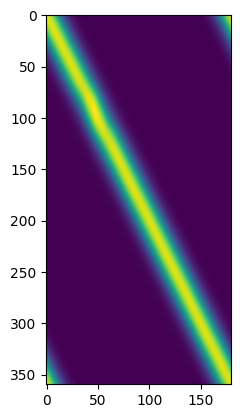

In [24]:

import numpy as np
import matplotlib.pyplot as plt

# === PARAMETERS ===
N_hd = 180
N_conj = 360
timesteps = 1000
delta_t = 0.0001
tau = 0.001
g_hd = 20
g_conj = 7

# Learning rate for HD → CONJ
k = 0.005

# Weight strengths and widths
w1_strength = 160
sigma_w1 = 20

# PFDs
x_hd = np.linspace(0, 360, N_hd, endpoint=False)
x_conj = np.linspace(0, 360, N_conj, endpoint=False)

# === FUNCTIONS ===
def circular_gaussian(x1, x2, sigma):
    delta = np.abs(x1[:, None] - x2[None, :])
    delta = np.minimum(delta, 360 - delta)
    return np.exp(-0.5 * (delta / sigma)**2)

# === INITIALIZATION ===
W1 = circular_gaussian(x_conj, x_hd, sigma_w1) * w1_strength  # HD → CONJ (learned)
W2 = circular_gaussian(x_hd, x_conj, sigma_w1) * 45           # CONJ → HD (fixed)

a_hd = np.zeros(N_hd)
r_hd = np.zeros(N_hd)
a_conj = np.zeros(N_conj)
r_conj = np.zeros(N_conj)

# Initialize x_true with starting direction
x_true = 90

# === SIMULATION ===
for t in range(timesteps):
    # Random walk update for head direction
    delta_theta = np.random.uniform(-1.0, 1.0)
    x_true = (x_true + delta_theta) % 360

    # Create input to HD layer based on current x_true
    delta = np.abs(x_hd - x_true)
    delta = np.minimum(delta, 360 - delta)
    hd_input = np.exp(-0.5 * (delta / 10)**2) * 4

    # HD dynamics (input from CONJ + external)
    conj_to_hd = (1 / N_conj) * W2 @ r_conj
    inhibition_hd = (g_hd / N_hd) * np.sum(r_hd)
    da_hd = (-a_hd - inhibition_hd + conj_to_hd + hd_input) / tau
    a_hd += da_hd * delta_t
    r_hd = np.maximum(0, np.tanh(a_hd))

    # CONJ dynamics (input from HD)
    hd_to_conj = (1 / N_hd) * W1 @ r_hd
    inhibition_conj = (g_conj / N_conj) * np.sum(r_conj)
    da_conj = (-a_conj - inhibition_conj + hd_to_conj) / tau
    a_conj += da_conj * delta_t
    r_conj = np.maximum(0, np.tanh(a_conj))

    # === HEBBIAN LEARNING (HD → CONJ) ===
    W1 += k * np.outer(r_conj, r_hd)

    # Normalize W1 rows (L2 norm = 1)
    norms = np.linalg.norm(W1, axis=1, keepdims=True)
    norms[norms == 0] = 1
    W1 /= norms

# === VISUALIZATION ===
plt.imshow(W1)

## 1. 🔄 Input in Each Simulation

The only **external driver** of the network is a **random walk of head direction**, represented by:

- `x_true`: the actual (true) head direction
- `x_est`: an **internal path integration estimate** of head direction, computed from `x_true` with added Gaussian noise

This estimate `x_est` serves as the basis for **path integration input to ADN**, simulating how the system integrates movement over time.

---

## 2. 🔁 Inputs to ADN Cells

Each ADN cell receives **four** inputs:

### ✅ a) Path Integration Input (PI)
- A Gaussian bump centered on `x_est`
- Implements:  
  \[
  \text{PI}_i = A_{\text{PI}} \cdot \exp\left(-\frac{(x_i - x_{\text{est}})^2}{2\sigma_{\text{PI}}^2}\right)
  \]
- Simulates egocentric motion-driven head estimation

### ✅ b) Recurrent ADN ↔ ADN input
- Via a pre-wired circular Gaussian matrix `W6`
- Implements mutual excitation between neighboring ADN cells to maintain bump stability

### ✅ c) Feedback from HD cells (HD → ADN)
- Computed via matrix `W5 @ r_hd`
- Each ADN cell receives input from HD cells based on pre-wired circular tuning

### ✅ d) Global Inhibition
- Proportional to the total firing across all ADN cells
- Implements divisive normalization to keep activity bounded

---

## 3. 🔁 Inputs to HD Cells

Each HD cell receives **three** inputs:

### ✅ a) Feedforward input from ADN cells (ADN → HD)
- Computed via `W4 @ r_adn`
- Pre-wired circular Gaussian (centered on PFD alignment)

### ✅ b) Feedback input from CONJ cells (CONJ → HD)
- Computed via `W2 @ r_conj`
- Pre-wired Gaussian-based matrix

### ✅ c) Global Inhibition
- Uniformly subtracted from all HD cells based on total HD activity
- Keeps bump stable and prevents runaway firing

### 🚫 No direct external input is used in this version (i.e., no visual cue or `x_true` injected directly)

---

## 4. 🔁 Inputs to CONJ Cells

Each CONJ cell receives **two** inputs:

### ✅ a) Feedforward input from HD cells (HD → CONJ)
- Computed via `W1 @ r_hd`
- **This matrix is plastic**: updated using a Hebbian learning rule:
  \[
  \Delta w_{ij} = k \cdot r_i^{\text{CONJ}} \cdot r_j^{\text{HD}}
  \]
- Normalized after every update (L2 norm)

### ✅ b) Global Inhibition
- As with other populations, CONJ cells receive inhibition proportional to total CONJ activity

---

## 🔚 Summary Table

| Cell Type | External Input | Feedforward Input | Feedback Input | Inhibition |
|-----------|----------------|-------------------|----------------|------------|
| **ADN**   | PI from `x_est` | ADN (W6)          | HD (W5)        | ✅          |
| **HD**    | ❌              | ADN (W4), CONJ (W2)| —              | ✅          |
| **CONJ**  | ❌              | HD (W1, learned)  | —              | ✅          |

Text(0.5, 1.0, 'Weights: HD to CONJ')

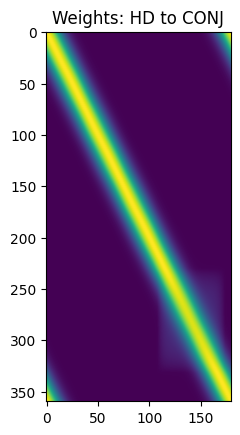

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === PARAMETERS ===
N_adn = 180
N_hd = 180
N_conj = 360
timesteps = 1000
delta_t = 0.0001
tau = 0.001

# Inhibition
g_adn = 5
g_hd = 20
g_conj = 7

# Learning rate and strengths
k = 0.005  # HD → CONJ learning
A_PI = 4
sigma_PI = 10

w4_strength = 120  # ADN → HD
w5_strength = 10   # HD → ADN
w1_strength = 160  # HD → CONJ
w2_strength = 45   # CONJ → HD

# Widths
sigma_adn = 10
sigma_w4 = 10
sigma_w5 = 10
sigma_w1 = 20
sigma_w2 = 20

# Preferred firing directions
x_adn = np.linspace(0, 360, N_adn, endpoint=False)
x_hd = np.linspace(0, 360, N_hd, endpoint=False)
x_conj = np.linspace(0, 360, N_conj, endpoint=False)

# === HELPER FUNCTION ===
def circular_gaussian(x1, x2, sigma):
    delta = np.abs(x1[:, None] - x2[None, :])
    delta = np.minimum(delta, 360 - delta)
    return np.exp(-0.5 * (delta / sigma)**2)

# === INITIALIZE WEIGHTS ===
W6 = circular_gaussian(x_adn, x_adn, sigma_adn)
W4 = circular_gaussian(x_hd, x_adn, sigma_w4) * w4_strength
W5 = circular_gaussian(x_adn, x_hd, sigma_w5) * w5_strength
W1 = circular_gaussian(x_conj, x_hd, sigma_w1) * w1_strength  # HD → CONJ (learned)
W2 = circular_gaussian(x_hd, x_conj, sigma_w2) * w2_strength  # CONJ → HD (fixed)

# === INITIALIZE STATES ===
a_adn = np.zeros(N_adn)
r_adn = np.zeros(N_adn)
a_hd = np.zeros(N_hd)
r_hd = np.zeros(N_hd)
a_conj = np.zeros(N_conj)
r_conj = np.zeros(N_conj)

# Initialize heading
x_est = 90
x_true_history = []
x_est_history = []

# === SIMULATION ===
for t in range(timesteps):
    # Random walk for x_true
    delta_theta = np.random.uniform(-1.0, 1.0)
    x_true = (x_true_history[-1] + delta_theta) % 360 if x_true_history else 90
    noise = np.random.normal(loc=0.005 * delta_theta, scale=0.005 * abs(delta_theta))
    x_est = (x_est + delta_theta + noise) % 360

    x_true_history.append(x_true)
    x_est_history.append(x_est)

    # === ADN Dynamics ===
    delta_PI = np.abs(x_adn - x_est)
    delta_PI = np.minimum(delta_PI, 360 - delta_PI)
    PI_input = A_PI * np.exp(-0.5 * (delta_PI / sigma_PI)**2)

    recurrent_adn = (1 / N_adn) * W6 @ r_adn
    inhibition_adn = (g_adn / N_adn) * np.sum(r_adn)
    hd_to_adn = (1 / N_hd) * W5 @ r_hd

    da_adn = (-a_adn - inhibition_adn + recurrent_adn + hd_to_adn + PI_input) / tau
    a_adn += da_adn * delta_t
    r_adn = np.maximum(0, np.tanh(a_adn))

    # === HD Dynamics ===
    adn_to_hd = (1 / N_adn) * W4 @ r_adn
    conj_to_hd = (1 / N_conj) * W2 @ r_conj
    inhibition_hd = (g_hd / N_hd) * np.sum(r_hd)

    da_hd = (-a_hd - inhibition_hd + adn_to_hd + conj_to_hd) / tau
    a_hd += da_hd * delta_t
    r_hd = np.maximum(0, np.tanh(a_hd))

    # === CONJ Dynamics ===
    hd_to_conj = (1 / N_hd) * W1 @ r_hd
    inhibition_conj = (g_conj / N_conj) * np.sum(r_conj)

    da_conj = (-a_conj - inhibition_conj + hd_to_conj) / tau
    a_conj += da_conj * delta_t
    r_conj = np.maximum(0, np.tanh(a_conj))

    # === LEARNING: HD → CONJ (W1) ===
    W1 += k * np.outer(r_conj, r_hd)
    norms = np.linalg.norm(W1, axis=1, keepdims=True)
    norms[norms == 0] = 1
    W1 /= norms

# === VISUALIZATION ===
plt.imshow(W1)
plt.title('Weights: HD to CONJ')
